In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import miniball
import math
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [2]:
subtask = 3
model_name = 'k-means'
if subtask == 3:
  model_name = 'DBSCAN'
file = open(f'R1{subtask}.txt','r')

In [3]:
d, n, m, k, p = list(map(int,file.readline().split()))
ks = list(map(int,file.readline().split()))
ar = []
for i in range(n):
  ar.append(list(map(float,file.readline().split())))
df = pd.DataFrame(ar)

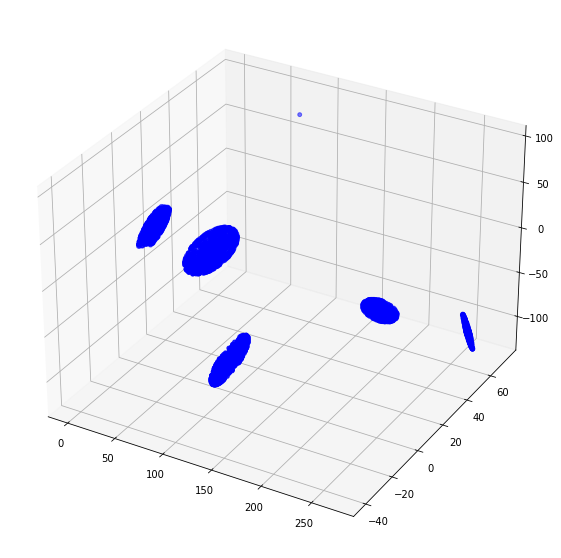

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(df[0])
y = np.array(df[1])
z = np.array(df[2])
ax.scatter(df[0], df[1], df[2], s=15, color='blue')
plt.show()

[  3.45124793   3.4681388    3.51632185   3.51656976   3.53031185
   3.53277621   3.58691607   3.82647605   3.91282013 112.73460726]


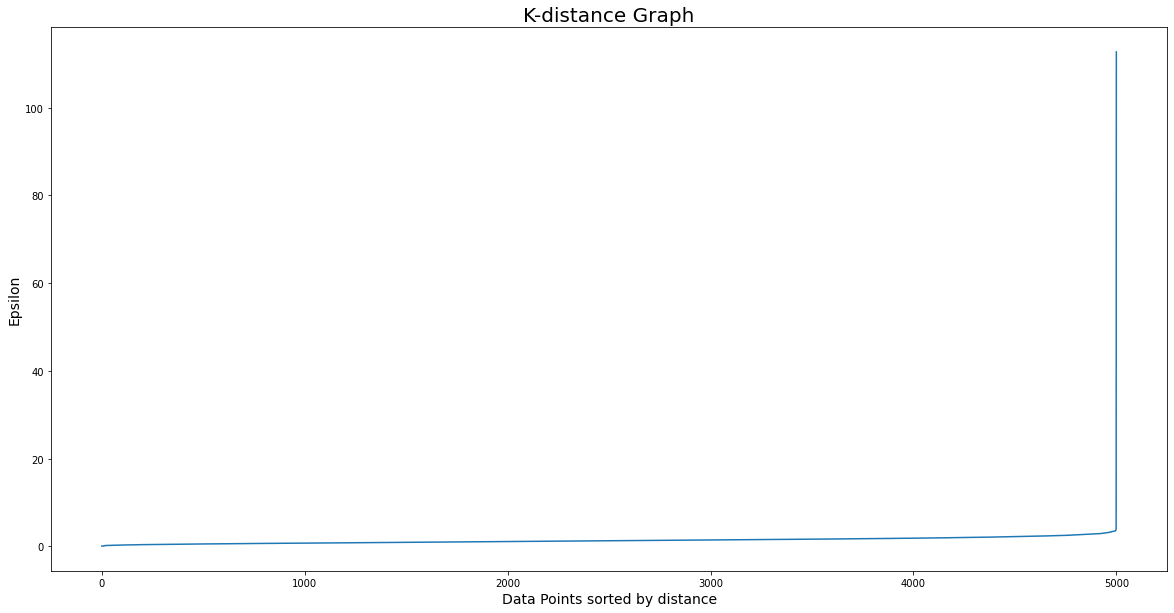

count    5001.00000
mean        1.99940
std         1.41485
min        -1.00000
25%         1.00000
50%         2.00000
75%         3.00000
max         4.00000
Name: labels, dtype: float64


In [5]:
if model_name == 'k-means':
  model=KMeans(n_clusters=k)
  model.fit(df[[i for i in range(d)]])
  df['labels'] = model.labels_
  centroids = model.cluster_centers_
elif model_name == 'hierarchical':
  model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
  model.fit(df[[i for i in range(d)]])
  df['labels'] = model.labels_
elif model_name == 'DBSCAN':
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(df[[i for i in range(d)]])
  distances, indices = nbrs.kneighbors(df[[i for i in range(d)]])
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.figure(figsize=(20,10))
  plt.plot(distances)
  print(distances[-10:])
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
  model = DBSCAN(eps=5, min_samples=4)
  model.fit(df[[i for i in range(d)]])
  df['labels'] = model.labels_
  print(df['labels'].describe())

In [6]:
centroids = [0 for i in range(k)]
radius = [0] * k

for i in range(k):
  points = df.loc[df['labels'] == i][[i for i in range(d)]].to_numpy()
  mb = miniball.Miniball(points)
  c = mb.center()
  r = math.sqrt(mb.squared_radius())
  centroids[i] = c
  radius[i] = r
  print(r, ' ', c)

16.00000000000001   [258.710757643248, 66.31687702359282, -107.05484433759338, -116.87598054064655]
16.0   [11.880315523616945, 6.183488550346029, 10.417713882691945, 11.895417574649809]
16.00000000000001   [73.58792605352471, 5.006932190671586, 4.944757671044387, -61.431475637371065]
16.000000000000004   [197.00314711334022, 42.699349195230916, -71.88354415522453, -56.76472680686163]
16.0   [135.29553658343247, -25.05557359527078, -55.88329130591015, -33.07014622183384]


model name: DBSCAN


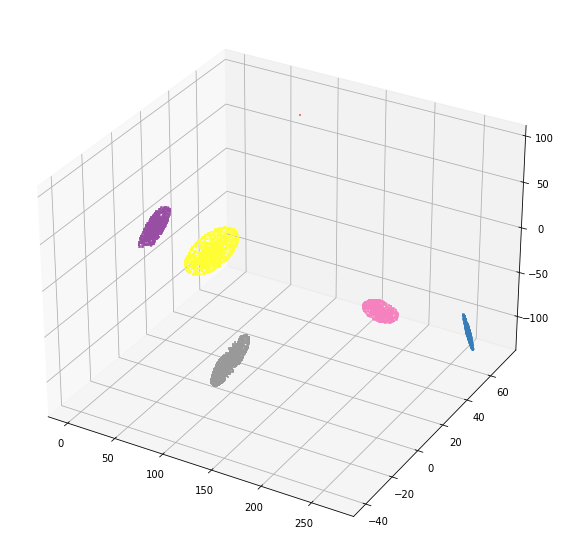

In [7]:
print(f'model name: {model_name}')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(df[0])
y = np.array(df[1])
z = np.array(df[2])
ax.scatter(x,y,z, marker="s", c=df['labels'], s=2, cmap="Set1")
# ax.view_init(90, angle)
plt.show()

In [8]:
def get_eigens(X):
    pca = PCA()
    pca.fit_transform(X)
    return pca.explained_variance_ratio_, pca.components_

def find_normal_vectors(eigens, vectors, THRESHOLD=0.001 / d):
  normal_vectors = []
  for i in range(len(eigens)):
    if eigens[i] < THRESHOLD:
      normal_vectors.append(vectors[i])
  return normal_vectors

values = []
vectors = []
for i in range(k):
    X = df.loc[df['labels'] == i]
    X = X[[i for i in range(d)]]
    s, v = get_eigens(X)
    values.append(s)
    vectors.append(v)

A = []
for i in range(k):
  print(values[i])
  A.append(find_normal_vectors(values[i],vectors[i]))
B = []
for i in range(k):
  b = []
  X = df.loc[df['labels'] == i][[i for i in range(d)]]
  mean = np.mean(X, axis=0)
  for j in range(len(A[i])):
    b.append(np.dot(A[i][j],mean))
  B.append(b)

[3.96354194e-01 3.72903022e-01 2.30742784e-01 3.22468301e-31]
[3.90641550e-01 3.77064646e-01 2.32293804e-01 2.59943476e-32]
[3.91260770e-01 3.76075824e-01 2.32663406e-01 1.34778411e-31]
[3.92883486e-01 3.69253172e-01 2.37863342e-01 2.94570165e-31]
[3.88440505e-01 3.66756588e-01 2.44802906e-01 7.97066230e-31]


In [9]:
vectors = [[] for i in range(k)]
outlier = []
for i in range(n):
  if df.at[i, 'labels'] == -1:
    outlier.append(i + 1)
  else:
    vectors[df.at[i, 'labels']].append(i + 1)

with open('output.txt', 'w') as f:
  print(f'{n} {m}', file=f)
  for i in range(k):
    dimension = d - len(A[i])
    print(f'{dimension} 1 Sphere', file=f)
    for j in range(0,len(A[i])):
      print(' '.join(list(map(str,A[i][j]))), file=f)
    print(' '.join(list(map(str,B[i]))), file=f)
    print(' '.join(list(map(str, centroids[i]))) + ' ' + str(radius[i]), file=f)
    print(str(len(vectors[i])) + ' ' + ' '.join(list(map(str, vectors[i]))), file=f)
  print(str(len(outlier)) + ' ' + ' '.join(list(map(str, outlier))), file=f)

